## 분석 준비: 데이터 로드 및 통합

In [1]:
import pandas as pd

### 데이터 로드

In [2]:
df = pd.read_csv('data/변수 통합_original.csv')
df_s = pd.read_csv('data/자치구별_학교수.csv')

### 데이터 병합

In [3]:
# 자치구 기준으로 병합
df_m = pd.merge(df, df_s, on='자치구', how='inner')
df_m.head()

,자치구,인구밀도,교통 편의성,문화 인프라 지수,예술인프라지수,의료 인프라 지수,상권_변화_지표,성장가능성,학교 수
0,종로구,6292.471769,0.414197,0.320997,0.000386,0.007703,HH,2,141
1,중구,13232.228916,0.448910,1.059722,0.000152,0.010380,HH,2,171
2,용산구,10384.362140,0.254171,0.061350,0.000053,0.003430,HH,2,125
3,성동구,16930.202140,0.375717,0.005239,0.000014,0.003880,LH,4,62
4,광진구,20584.994138,0.236879,0.015377,0.000009,0.003833,LL,1,116


#### 

### 학교 변수도 추가한 데이터셋을 새로운 csv파일로 저장

In [4]:
df_m.to_csv("./data/변수 통합_original2.csv", index=False, encoding='utf-8-sig')


#### 

## 데이터 분석: 발표 때 언급하지 않은 부분

### ❗ 문화 인프라 지수는 NaN 값 포함 → 예술인프라지수로 대체  
  
✅ 표준화 필요 이유:  
인구밀도, 교통 편의성 등 단위가 다 다르기 때문에  
회귀 및 트리 기반 모델의 안정적 학습을 위해 StandardScaler 사용  
  
✅ NaN 제거 이유:  
모델은 결측값을 처리하지 못하므로 예술인프라지수 등 분석 대상 중 NaN 포함된 행 제거  
  
✅ stratify 옵션:  
타깃(y)의 비율이 유지되도록 train/test 분할 (분류 모델에서 중요)  

In [5]:
# 혹시 모를 상황을 대비해 df_temp5의 복사본 사용
df_merge = df_m.copy()


In [6]:
# 시각화 준비
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 무시
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (윈도우 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


📊 [다항 로지스틱 회귀 계수]
         인구밀도    교통 편의성   예술인프라지수  의료 인프라 지수      학교 수
클래스                                                   
1   -0.364776 -0.890834 -0.775239   0.416028  0.726677
2    0.162894  0.078216  0.616487   0.604730 -0.560057
3    0.427991  0.680129 -0.073925  -0.293738  0.164779
4   -0.226109  0.132489  0.232676  -0.727020 -0.331399

📈 [분류 정확도]
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1

    accuracy                           0.40         5
   macro avg       0.22      0.22      0.22         5
weighted avg       0.40      0.40      0.40         5



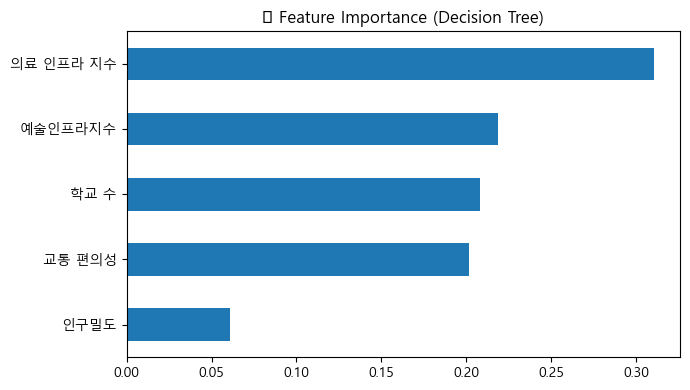

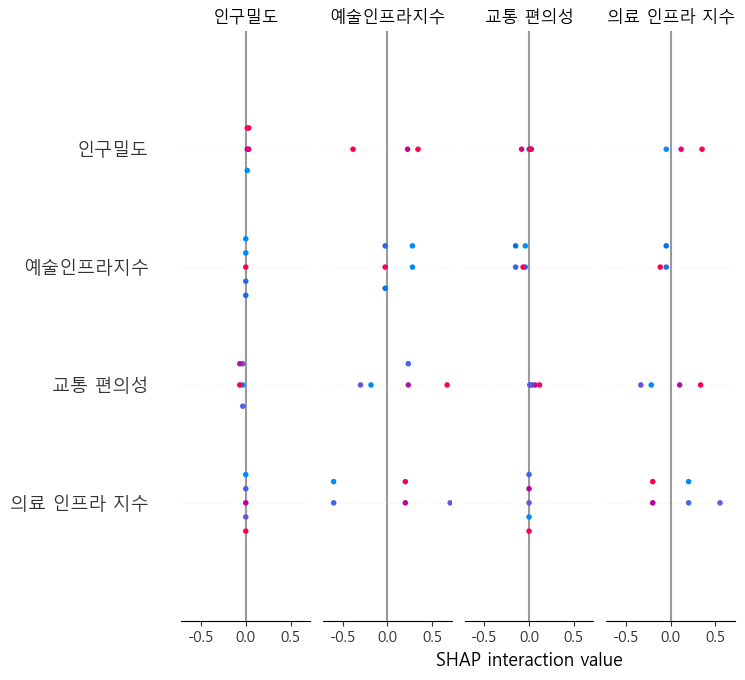

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 1. 데이터 준비
df = df_merge.copy()

# 2. 사용하지 않을 컬럼 제거 및 필요한 컬럼만 선택
# - 문화 인프라 지수는 관악구 NaN 있으므로 제외
# - 상권_변화_지표는 문자열형이므로 현재 분석에서는 사용하지 않음
X = df[['인구밀도', '교통 편의성', '예술인프라지수', '의료 인프라 지수', '학교 수']]
y = df['성장가능성']

# 3. NaN 처리
X = X.dropna()
y = y.loc[X.index]  # X와 y의 인덱스 일치시킴

# 4. 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. 학습/검증 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# ===============================
# ⬛ 1. 다항 로지스틱 회귀 분석
# ===============================
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logreg.fit(X_train, y_train)

# 계수 확인 (설명력 분석)
coeff_df = pd.DataFrame(logreg.coef_, columns=X.columns)
coeff_df['클래스'] = logreg.classes_
print("📊 [다항 로지스틱 회귀 계수]")
print(coeff_df.set_index('클래스'))

# 정확도 보고
print("\n📈 [분류 정확도]")
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

# =====================================
# ⬛ 2. 결정트리 기반 Feature Importance
# =====================================
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# 시각화
feat_imp = pd.Series(tree.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', title='🎯 Feature Importance (Decision Tree)', figsize=(7,4))
plt.tight_layout()
plt.show()

# ========================
# ⬛ 3. SHAP 기반 설명 분석
# ========================
explainer = shap.Explainer(tree, X_train)
shap_values = explainer(X_test)

# summary plot
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)


다항 로지스틱 회귀 계수 해석:
인구밀도와 교통 편의성이 성장 가능성이 높은 클래스(3) 에 양의 영향을 주는 반면, 클래스 1에서는 음의 계수를 가지는 등, 특성별로 클래스 간 확실한 경향 차이가 존재합니다.

모델 성능 문제:
클래스 2, 4의 지원 샘플이 너무 적어 모델이 해당 클래스를 학습하지 못하고 있음 → 데이터 불균형이 심각
→ 이 문제를 해결하지 않으면 해석도, 예측도 모두 신뢰하기 어려움

의사결정나무 기반 feature importance:
의료 인프라 지수가 가장 중요한 특성으로 나타나며, 모델이 주요 기준으로 삼는 변수임을 의미합니다.
하지만 단일 변수의 영향만 보기 때문에 SHAP과 병행해서 해석하는 것이 매우 바람직합니다.

SHAP interaction values:
변수 간의 상호작용 효과까지 해석할 수 있다는 점에서 매우 유용
특히, 단일 변수 해석이 혼란스러운 경우(예: 의료 인프라 지수가 클래스에 따라 상반된 계수 가짐), 다변량 맥락에서의 기여도 파악 가능

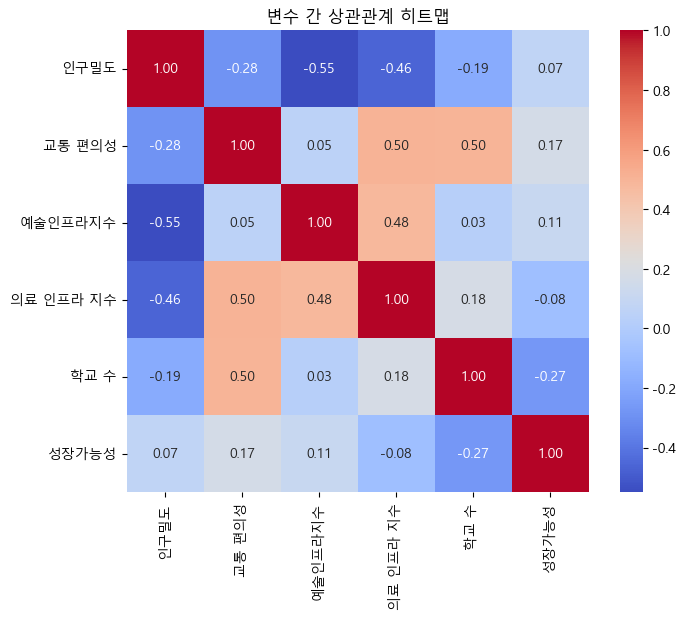

In [10]:
# 일반 히트맵
import seaborn as sns
import matplotlib.pyplot as plt

# 상관행렬 계산 (숫자형 변수만)
corr_matrix = df_merge[['인구밀도', '교통 편의성', '예술인프라지수', '의료 인프라 지수','학교 수', '성장가능성']].corr()

# 히트맵 시각화
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f")
plt.title('변수 간 상관관계 히트맵')
plt.show()
